<a href="https://colab.research.google.com/github/hrtnisri2016/fcc-ml-python-projects/blob/main/fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Book Recommendation Engine using KNN

In this notebook, I'll demonstrate how to create a book recommendation algorithm using K-Nearest Neighbors. Since the Nearest Neighbors method uses distance to measure how "close" two instances are to one another, this will be able to display books that are similar to a specific book. So, we'll write a function called `get_recommends` that accepts a book title (from the dataset) as an argument and outputs a list of 5 books that are relevant to the book argument, along with their distances from it. 

The [Book Crossings dataset](https://cdn.freecodecamp.org/project-data/books/book-crossings.zip) will be utilized. This dataset contains 1.1 million ratings (on a scale of 0-10) of 270,000 books by 90,000 users.

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

## Load data

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2022-12-10 05:46:19--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  23.9MB/s    in 1.0s    

2022-12-10 05:46:20 (23.9 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [3]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [4]:
# view the first 5 rows of df_books
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [5]:
# view the first 5 rows of df_ratings
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [6]:
# check data shape
print(df_books.shape)
print(df_ratings.shape)

(271379, 3)
(1149780, 3)


## Data Preparation

**Remove any null values that exist**

In [7]:
df_books.isna().sum()

isbn      0
title     0
author    1
dtype: int64

In [8]:
df_books.dropna(inplace=True)

In [9]:
df_ratings.isna().sum()

user      0
isbn      0
rating    0
dtype: int64

## Data preparation

If we graph the dataset (which I don't do for the book's `isbn`), you will notice that most books are not rated frequently. To ensure statistical significance, remove users with less than 200 ratings and books with less than 100 ratings from the dataset.

In [10]:
user_rating_count = df_ratings.user.value_counts()
print(user_rating_count)

11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
116180        1
116166        1
116154        1
116137        1
276723        1
Name: user, Length: 105283, dtype: int64


In [11]:
book_rating_count = df_ratings.isbn.value_counts()
print(book_rating_count)

0971880107     2502
0316666343     1295
0385504209      883
0060928336      732
0312195516      723
               ... 
1568656386        1
1568656408        1
1569551553        1
1570081808        1
05162443314       1
Name: isbn, Length: 340556, dtype: int64


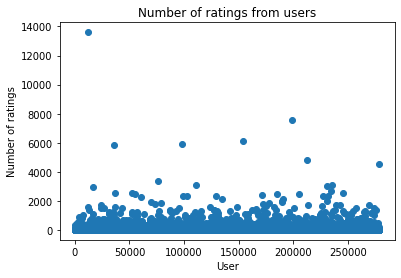

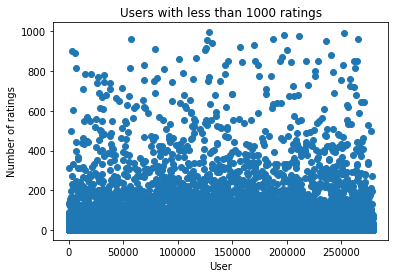

In [12]:
plt.scatter(user_rating_count.index, user_rating_count)
plt.xlabel('User')
plt.ylabel('Number of ratings')
plt.title('Number of ratings from users')

plt.figure()
plt.scatter(user_rating_count[user_rating_count < 1000].index, user_rating_count[user_rating_count < 1000])
plt.xlabel('User')
plt.ylabel('Number of ratings')
plt.title('Users with less than 1000 ratings')

plt.show()

**Remove users with less than 200 ratings and books with less than 100 ratings from `df_ratings`**

In [13]:
saved_users = user_rating_count[user_rating_count < 200]
df_ratings_clean = df_ratings[~df_ratings.user.isin(saved_users.index)]
print(df_ratings_clean.shape)

(527556, 3)


In [14]:
saved_books = book_rating_count[book_rating_count < 100]
df_ratings_clean = df_ratings_clean[~df_ratings_clean.isbn.isin(saved_books.index)]
print(df_ratings_clean.shape)

(49781, 3)


In [15]:
df_ratings_clean.head()

,user,isbn,rating
1456,277427,002542730X,10.0
1469,277427,0060930535,0.0
1471,277427,0060934417,0.0
1474,277427,0061009059,9.0
1484,277427,0140067477,0.0


In [16]:
df_ratings_final = df_ratings_clean.merge(df_books, on='isbn', how='inner')
df_ratings_final

,user,isbn,rating,title,author
0,277427,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
1,3363,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
2,11676,002542730X,6.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
3,12538,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
4,13552,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
...,...,...,...,...,...
49512,238864,0399149325,0.0,Portrait of a Killer: Jack the Ripper -- Case ...,Patricia Cornwell
49513,251843,0399149325,1.0,Portrait of a Killer: Jack the Ripper -- Case ...,Patricia Cornwell
49514,253821,0399149325,0.0,Portrait of a Killer: Jack the Ripper -- Case ...,Patricia Cornwell
49515,265115,0399149325,0.0,Portrait of a Killer: Jack the Ripper -- Case ...,Patricia Cornwell


**Prepare the dataset for kNN**

In [17]:
df = df_ratings_final.pivot_table(index=['user'], columns=['title'],values='rating').fillna(0).T
df.head()

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df.index

Index(['1984', '1st to Die: A Novel', '2nd Chance', '4 Blondes',
       'A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash',
       'A Bend in the Road', 'A Case of Need',
       'A Child Called \It\": One Child's Courage to Survive"',
       'A Civil Action', 'A Confederacy of Dunces (Evergreen Book)',
       ...
       'Wicked: The Life and Times of the Wicked Witch of the West', 'Wifey',
       'Wild Animus', 'Winter Moon', 'Wish You Well', 'Without Remorse',
       'Year of Wonders', 'You Belong To Me',
       'Zen and the Art of Motorcycle Maintenance: An Inquiry into Values',
       '\O\" Is for Outlaw"'],
      dtype='object', name='title', length=673)

## Build model

In [19]:
model = NearestNeighbors(metric='cosine')
model.fit(df.values)

NearestNeighbors(metric='cosine')

In [20]:
# function to return recommended books
def get_recommends(title = ""):
    # make sure the title is in the database
    try:
        book = df.loc[title]
    except KeyError as e:
        return f'The book {e} does not exist in the database.'
    
    # predict 2D array of book.values into the model;
    # since we want to acquire five suggested books, we use six neighbors 
    # because the first (the closest book title) is the actual book
    distance, idx = model.kneighbors([book.values], n_neighbors=6)

    # to make it simpler to sort the distance values, 
    # put the output into a dataframe and get the values at the end
    recommended_books = pd.DataFrame({
      'title'   : df.iloc[idx[0]].index.values,
      'distance': distance[0]
    }) \
    .sort_values(by='distance', ascending=False) \
    .head(5).values
    
    return [title, recommended_books]

Let's verify that the function is working before performing the actual test.

This code:
```
get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")
```
should return:
```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

In [21]:
get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")

['The Queen of the Damned (Vampire Chronicles (Paperback))',
 array([['Catch 22', 0.793983519077301],
        ['The Witching Hour (Lives of the Mayfair Witches)',
         0.7448656558990479],
        ['Interview with the Vampire', 0.7345068454742432],
        ['The Tale of the Body Thief (Vampire Chronicles (Paperback))',
         0.5376338362693787],
        ['The Vampire Lestat (Vampire Chronicles, Book II)',
         0.5178411602973938]], dtype=object)]

## Test

In [22]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", array([["I'll Be Seeing You", 0.8016210794448853],
       ['The Weight of Water', 0.7708583474159241],
       ['The Surgeon', 0.7699410915374756],
       ['I Know This Much Is True', 0.7677075266838074],
       ['The Lovely Bones: A Novel', 0.7234864234924316]], dtype=object)]
You passed the challenge! 🎉🎉🎉🎉🎉


## Additional things you might find interesting

I initially tried to prepare the data in a different way. Unfortunately, the test was unsuccessful. But as an added bonus to this notebook, I'd like to leave it here.

In [23]:
# How many unique books
print(df_books.nunique())

isbn      271378
title     242153
author    102042
dtype: int64


In [24]:
# How many unique users
print(df_ratings.nunique())

user      105283
isbn      340556
rating        11
dtype: int64


In [25]:
df_books[df_books['title'].duplicated(keep=False)].sort_values('title')

,isbn,title,author
75640,1565920465,!%@ (A Nutshell handbook),Donnalyn Frey
156349,1565920317,!%@ (A Nutshell handbook),Donnalyn Frey
140624,0792276833,'A Hell of a Place to Lose a Cow': An American...,Tim Brookes
158213,0792277295,'A Hell of a Place to Lose a Cow': An American...,Tim Brookes
10439,0451168089,'Salem's Lot,Stephen King
...,...,...,...
193447,0316507490,dot.bomb: My Days and Nights at an Internet Go...,J. David Kuo
164122,158621182X,dot.bomb: My Days and Nights at an Internet Go...,J. David Kuo
193468,0316089702,dot.bomb: My Days and Nights at an Internet Go...,J. David Kuo
197396,3492233376,Ã?Â?berleben in der WÃ?Â¼ste Danakil.,RÃ?Â¼diger Nehberg


It seems like some ISBNs have the same author and book title, which is possible when a separate ISBN is assigned to each edition and variation of a publication. So, I would like to include a `title` column in the `df_ratings` table so I can count the number of ratings for each book appropriately.

In [26]:
df_ratings_new = df_ratings.merge(df_books[['isbn', 'title', 'author']], how='inner', on='isbn')
df_ratings_new = df_ratings_new.drop(columns=['isbn'])
df_ratings_new

,user,rating,title,author
0,276725,0.0,Flesh Tones: A Novel,M. J. Rose
1,2313,5.0,Flesh Tones: A Novel,M. J. Rose
2,6543,0.0,Flesh Tones: A Novel,M. J. Rose
3,8680,5.0,Flesh Tones: A Novel,M. J. Rose
4,10314,9.0,Flesh Tones: A Novel,M. J. Rose
...,...,...,...,...
1031169,276688,0.0,Mostly Harmless,Douglas Adams
1031170,276688,7.0,Gray Matter,Shirley Kennett
1031171,276690,0.0,Triplet Trouble and the Class Trip (Triplet Tr...,Debbie Dadey
1031172,276704,0.0,A Desert of Pure Feeling (Vintage Contemporaries),Judith Freeman


It's also possible that different authors have the same book title. However, I believe it won't hurt to assume that the same book title comes from the same author, as the aim of this project is to create book recommendations solely based on the book title.

In [27]:
df_ratings_new[df_ratings_new.duplicated(keep=False)].sort_values(['user', 'title'])

,user,rating,title,author
194264,254,0.0,Cat's Cradle,Kurt Vonnegut
197434,254,0.0,Cat's Cradle,Kurt Vonnegut
12722,254,9.0,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling
54082,254,9.0,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling
54433,254,9.0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling
...,...,...,...,...
151365,278418,0.0,The Witness,Sandra Brown
55396,278418,0.0,Vanished,Danielle Steel
143992,278418,0.0,Vanished,Danielle Steel
167429,278418,0.0,Wee Sing Nursery Rhymes &amp; Lullabies,Pamela Conn Beall


In [28]:
df_ratings_new.drop_duplicates(keep='first', inplace=True)
print(df_ratings_new.shape)

(1028937, 4)


In [29]:
user_ratings = df_ratings_new.user.value_counts()
users = user_ratings[user_ratings < 200]

df_ratings_final = df_ratings_new[~df_ratings_new.user.isin(users.index)]
print(df_ratings_final.shape)

(472462, 4)


In [30]:
book_ratings = df_ratings_new.title.value_counts()
titles = book_ratings[book_ratings < 100]

df_ratings_final = df_ratings_final[~df_ratings_final.title.isin(titles.index)]
print(df_ratings_final.shape)

(65327, 4)


In [31]:
df_ratings_final

,user,rating,title,author
63,278418,0.0,The Notebook,Nicholas Sparks
65,3363,0.0,The Notebook,Nicholas Sparks
66,7158,10.0,The Notebook,Nicholas Sparks
69,11676,10.0,The Notebook,Nicholas Sparks
74,23768,6.0,The Notebook,Nicholas Sparks
...,...,...,...,...
1027961,269566,0.0,Echoes,Maeve Binchy
1028815,271284,0.0,The Rainmaker,John Grisham
1029108,271705,0.0,Fahrenheit 451,Ray Bradbury
1030862,275970,0.0,Stormy Weather,Guy Dauncey


**Prepare the dataset for kNN**

In [32]:
df_knn = df_ratings_final.pivot_table(index=['user'],columns=['title'],values='rating').fillna(0).T
df_knn.head()

user,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24 Hours,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
df_knn.index

Index(['1984', '1st to Die: A Novel', '24 Hours', '2nd Chance', '4 Blondes',
       '84 Charing Cross Road',
       'A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash',
       'A Bend in the Road', 'A Case of Need',
       'A Child Called \It\": One Child's Courage to Survive"',
       ...
       'Without Remorse', 'Wizard and Glass (The Dark Tower, Book 4)',
       'Women Who Run with the Wolves',
       'Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players',
       'Wuthering Heights', 'Year of Wonders', 'You Belong To Me',
       'Zen and the Art of Motorcycle Maintenance: An Inquiry into Values',
       'Zoya', '\O\" Is for Outlaw"'],
      dtype='object', name='title', length=909)